# Importar as bibliotecas necessárias

In [1]:
import os
from os import listdir
from os.path import isfile, join

import shutil

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf


import PIL
import PIL.Image

# Carregar os nomes das imagens para realizar a seleção dos grupos de treinamento, validação e teste

In [2]:
# A intenção aqui é criar uma lista com os nomes dos arquivos para conseguir fazer um processamento em cima dos nomes
# e posteriormente criar os grupos de treinamento, validação e teste
# Neste processo acabei percebendo que três imagens de gatos estavam no formato .mat, então tive que excluí-las 
# da base original. As imagens são: Abyssinian_100, Abyssinian_101, Abyssinian_102
mypath = './images'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg',
 'Abyssinian_108.jpg',
 'Abyssinian_109.jpg',
 'Abyssinian_11.jpg',
 'Abyssinian_110.jpg',
 'Abyssinian_111.jpg',
 'Abyssinian_112.jpg',
 'Abyssinian_113.jpg',
 'Abyssinian_114.jpg',
 'Abyssinian_115.jpg',
 'Abyssinian_116.jpg',
 'Abyssinian_117.jpg',
 'Abyssinian_118.jpg',
 'Abyssinian_119.jpg',
 'Abyssinian_12.jpg',
 'Abyssinian_120.jpg',
 'Abyssinian_121.jpg',
 'Abyssinian_122.jpg',
 'Abyssinian_123.jpg',
 'Abyssinian_124.jpg',
 'Abyssinian_125.jpg',
 'Abyssinian_126.jpg',
 'Abyssinian_127.jpg',
 'Abyssinian_128.jpg',
 'Abyssinian_129.jpg',
 'Abyssinian_13.jpg',
 'Abyssinian_130.jpg',
 'Abyssinian_131.jpg',
 'Abyssinian_132.jpg',
 'Abyssinian_133.jpg',
 'Abyssinian_134.jpg',
 'Abyssinian_135.jpg',
 'Abyssinian_136.jpg',
 'Abyssinian_137.jpg',
 'Abyssinian_138.

In [3]:
# Esta análise é somente para obter uma média do tamanho em pixels das imagens e definir um tamanho de entrada do modelo

widths = []
heights = []

for img in listdir(mypath):
    img_path = join(mypath, img) # Making image file path
    im = PIL.Image.open(img_path)
    widths.append(im.size[0])
    heights.append(im.size[1])

AVG_HEIGHT = round(sum(heights)/len(heights))
AVG_WIDTH = round(sum(widths)/len(widths))
print(f'Largura média: {AVG_WIDTH} pixels. Altura média: {AVG_HEIGHT} pixels.')

Largura média: 437 pixels. Altura média: 391 pixels.


In [4]:
# Criar uma tabela do Pandas para carregar o nome da imagem, a espécie do animal e
# a raça do animal
ml_df = pd.DataFrame(columns = ['filename', 'species','breed'])
ml_df['filename'] = onlyfiles

In [5]:
# Os nomes dos arquivos foram processados para obter a espécie e a raça do animal em cada foto
# Segundo o próprio site que fornece a base de dados, arquivos que começam com letra maiúscula são gatos e com minúscula são
# cachorros. O nome da raça é feito separando a string usando o _
for i in ml_df.index:
    ml_df['breed'][i] = '_'.join(ml_df['filename'][i].split('_')[:-1])
    if ml_df['filename'][i][0].isupper():
        ml_df['species'][i] = 'cat'
    else:
        ml_df['species'][i] = 'dog'

In [6]:
ml_df.head()

,filename,species,breed
0,Abyssinian_1.jpg,cat,Abyssinian
1,Abyssinian_10.jpg,cat,Abyssinian
2,Abyssinian_100.jpg,cat,Abyssinian
3,Abyssinian_101.jpg,cat,Abyssinian
4,Abyssinian_102.jpg,cat,Abyssinian


In [7]:
# Verificando a quantidade de imagens em cada raça e espécie
ml_df.groupby(['species', 'breed']).size()

species  breed                     
cat      Abyssinian                    200
         Bengal                        200
         Birman                        200
         Bombay                        200
         British_Shorthair             200
         Egyptian_Mau                  200
         Maine_Coon                    200
         Persian                       200
         Ragdoll                       200
         Russian_Blue                  200
         Siamese                       200
         Sphynx                        200
dog      american_bulldog              200
         american_pit_bull_terrier     200
         basset_hound                  200
         beagle                        200
         boxer                         200
         chihuahua                     200
         english_cocker_spaniel        200
         english_setter                200
         german_shorthaired            200
         great_pyrenees                200
         havanese 

In [8]:
ml_df.groupby(['species']).size()

species
cat    2400
dog    4990
dtype: int64

A partir das análises acima podemos perceber que há quase a mesma quantidade de imagens para cada raça de gatos ou cachorros, no entanto precisamos selecionar apenas 2000 imagens no total. Para isso, foram feitos alguns passos a seguir para garantir o maior balanceamento possível das raças de cada animal com o intuito de não enviesar o modelo para uma raça ou outra. 
Basicamente vamos pegar mil imagens de gatos e mil de cachorros. Agora, para cada espécie, vamos pegar a mesma quantidade de imagens de cada raça.

In [9]:
# Criando uma função para separar exatamente a quantidade de interesse em cada espécie e raça
# Essa função é bem personalizada para esta necessidade, então ela recebe a base de dados dataframe, a raça desejada c_name,
# a quantidade escolhida de imagens t_number e a quantidade de imagens a ser removida remove_n
def create_sample(dataframe, c_name, t_number, remove_n=0):
    """
    Esta função retorna uma base de dados de cachorros ou gatos com apenas a quantidade escolhida
    de imagens para cada raça. Se for necessário, podem ser removidas n imagens usando remove_n
    """
    ml_class = dataframe[dataframe['species'] == c_name][['filename','breed']].copy()
    sampled_df = ml_class.groupby('breed', group_keys=False).apply(lambda df: df.sample(t_number, random_state=42)).copy()
    if remove_n > 0:
        drop_indices = np.random.choice(sampled_df.index, remove_n, replace=False)
        sampled_df = sampled_df.drop(drop_indices)
    return sampled_df

In [10]:
# Como há 25 raças de cachorro e serão escolhidas apenas 1000 imagens dessa espécie, 
# então cada raça ficará com 1000/25 = 40 imagens
sampled_dog = create_sample(ml_df, 'dog', 40)

In [11]:
sampled_dog.groupby(['breed']).size(), sampled_dog.count()

(breed
 american_bulldog              40
 american_pit_bull_terrier     40
 basset_hound                  40
 beagle                        40
 boxer                         40
 chihuahua                     40
 english_cocker_spaniel        40
 english_setter                40
 german_shorthaired            40
 great_pyrenees                40
 havanese                      40
 japanese_chin                 40
 keeshond                      40
 leonberger                    40
 miniature_pinscher            40
 newfoundland                  40
 pomeranian                    40
 pug                           40
 saint_bernard                 40
 samoyed                       40
 scottish_terrier              40
 shiba_inu                     40
 staffordshire_bull_terrier    40
 wheaten_terrier               40
 yorkshire_terrier             40
 dtype: int64,
 filename    1000
 breed       1000
 dtype: int64)

In [12]:
# Para os gatos, a divisão para cada raça é 1000/12 = 83,333... então serão escolhidos 84 imagens inicialmente
# e como 12*84 = 1008, 8 imagens serão removidas aleatóriamente das raças de gatos
sampled_cat = create_sample(ml_df, 'cat', 84, 8)

In [13]:
sampled_cat.groupby(['breed']).size(), sampled_cat.count()

(breed
 Abyssinian           82
 Bengal               84
 Birman               84
 Bombay               84
 British_Shorthair    84
 Egyptian_Mau         84
 Maine_Coon           84
 Persian              83
 Ragdoll              83
 Russian_Blue         82
 Siamese              82
 Sphynx               84
 dtype: int64,
 filename    1000
 breed       1000
 dtype: int64)

## Divisão dos grupos de treinamento, validação e teste

Nesta parte será criada uma base de teste com 20% do total de dados e uma base de validação com 10% dos dados de treinamento

In [14]:
# Esta função é específica para esta aplicação. Com ela é possível fazer uma divisão da base de dados garantindo que 
# cada base criada possua aproximadamente a mesma quantidade de imagens de cada espécie e raça de animal 
def train_val_test(dataframe, test_size, val_size):
    """Esta função divide o dataframe inserido em três novos dataframes usando os valores indicados em test_size e
    val_size. Os dataframes criados são para treinamento, validação e teste do modelo.
    Lembrando que test_size se refere à fração do total de instâncias no dataframe e val_size se refere ao total 
    de instâncias somente do conjunto de treinamento.
    Retorno: sampled_train, sampled_val, sampled_test """
    sampled_test = dataframe.groupby('breed', group_keys=False).apply(lambda df: df.sample(frac=test_size)).copy()
    sampled_train_val = dataframe[~dataframe.index.isin(sampled_test.index)]
    sampled_val = sampled_train_val.groupby('breed', group_keys=False).apply(lambda df: df.sample(frac=val_size)).copy()
    sampled_train = sampled_train_val[~sampled_train_val.index.isin(sampled_val.index)]
    return sampled_train, sampled_val, sampled_test

In [15]:
train_cat, val_cat, test_cat = train_val_test(sampled_cat, 0.2, 0.1)
train_cat.groupby(['breed']).size(), val_cat.groupby(['breed']).size(), test_cat.groupby(['breed']).size()

(breed
 Abyssinian           59
 Bengal               60
 Birman               60
 Bombay               60
 British_Shorthair    60
 Egyptian_Mau         60
 Maine_Coon           60
 Persian              59
 Ragdoll              59
 Russian_Blue         59
 Siamese              59
 Sphynx               60
 dtype: int64,
 breed
 Abyssinian           7
 Bengal               7
 Birman               7
 Bombay               7
 British_Shorthair    7
 Egyptian_Mau         7
 Maine_Coon           7
 Persian              7
 Ragdoll              7
 Russian_Blue         7
 Siamese              7
 Sphynx               7
 dtype: int64,
 breed
 Abyssinian           16
 Bengal               17
 Birman               17
 Bombay               17
 British_Shorthair    17
 Egyptian_Mau         17
 Maine_Coon           17
 Persian              17
 Ragdoll              17
 Russian_Blue         16
 Siamese              16
 Sphynx               17
 dtype: int64)

In [16]:
train_dog, val_dog, test_dog = train_val_test(sampled_dog, 0.2, 0.1)
train_dog.groupby(['breed']).size(), val_dog.groupby(['breed']).size(), test_dog.groupby(['breed']).size()

(breed
 american_bulldog              29
 american_pit_bull_terrier     29
 basset_hound                  29
 beagle                        29
 boxer                         29
 chihuahua                     29
 english_cocker_spaniel        29
 english_setter                29
 german_shorthaired            29
 great_pyrenees                29
 havanese                      29
 japanese_chin                 29
 keeshond                      29
 leonberger                    29
 miniature_pinscher            29
 newfoundland                  29
 pomeranian                    29
 pug                           29
 saint_bernard                 29
 samoyed                       29
 scottish_terrier              29
 shiba_inu                     29
 staffordshire_bull_terrier    29
 wheaten_terrier               29
 yorkshire_terrier             29
 dtype: int64,
 breed
 american_bulldog              3
 american_pit_bull_terrier     3
 basset_hound                  3
 beagle               

## Salvar as imagens nas pastas corretamente para aproveitar as ferramentas do tensorflow

Agora que as bases de treinamento, validação e teste foram criadas, as imagens serão salvas em uma estrutura organizada de tal forma a aproveitar a ferramente tf.keras.utils.image_dataset_from_directory do TensorFlow para facilitar todo o processo de treinamento do modelo de classificação

In [17]:
# Criando função para salvar os dados em uma pasta escolhida
def save_image(dataframe, src_dir, dst_dir):
    """
    Esta função salva todas as imagens indicadas no dataframe de entrada usando
    a origem (src_dir) e destinos (dst_dir) indicados
    """
    for i in dataframe.filename:
        origin = join(src_dir, i)
        #print(origin)
        destination = join(dst_dir, i)
        #print(destination)
        shutil.copy(origin, destination)

In [18]:
#Dicionario indicando o dataframe usado e onde salvar todos os arquivos em suas devidas pastas
destinations = {
    'train_dog' : [train_dog, './dataset/train/dog'],
    'val_dog'   : [val_dog, './dataset/validation/dog'],
    'test_dog'  : [test_dog, './dataset/test/dog'],
    'train_cat' : [train_cat, './dataset/train/cat'],
    'val_cat'   : [val_cat, './dataset/validation/cat'], 
    'test_cat'  : [test_cat, './dataset/test/cat']}

#Criar automaticamente as pastas necessárias
for i in destinations:
    try:
        os.makedirs(destinations[i][1])
    except OSError:
        print ("Creation of the directory %s failed" % destinations[i][1])
    else:
        print ("Successfully created the directory %s " % destinations[i][1])

#Salvar as imagens
for i in destinations:
    try:
        save_to = destinations[i][1]
        save_image(destinations[i][0], mypath, save_to)
        print (f"Successfully saved images to {destinations[i][1]}")
    except OSError:
        print (f"Saving to {destinations[i][1]} failed")

Successfully created the directory ./dataset/train/dog 
Successfully created the directory ./dataset/validation/dog 
Successfully created the directory ./dataset/test/dog 
Successfully created the directory ./dataset/train/cat 
Successfully created the directory ./dataset/validation/cat 
Successfully created the directory ./dataset/test/cat 
Successfully saved images to ./dataset/train/dog
Successfully saved images to ./dataset/validation/dog
Successfully saved images to ./dataset/test/dog
Successfully saved images to ./dataset/train/cat
Successfully saved images to ./dataset/validation/cat
Successfully saved images to ./dataset/test/cat


# Começar a efetivamente preparar os dados para o modelo

A partir deste momento, os dados estão preparados para aproveitar o que é ensinado no próprio site do TensorFlow. (vide https://www.tensorflow.org/tutorials/images/transfer_learning).

Isso tudo porque tanto o modelo quanto o processo apresentados estão bem ajustados para serem eficientes.

In [19]:
# Aqui são indicadas as localizações das bases de treinamento, validação e teste
train_dir = './dataset/train'
validation_dir = './dataset/validation'
test_dir = './dataset/test'

# Aqui a quantidade de imagens por lote para treinamento e tamanho da imagem de entrada
# Aqui escolhi o maior tamanho de entrada disponível para o modelo tento em vista que as imagens da base de dados possuem um 
# tamanho médio maior que este escolhido.
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1440 files belonging to 2 classes.


In [20]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 159 files belonging to 2 classes.


In [21]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 401 files belonging to 2 classes.


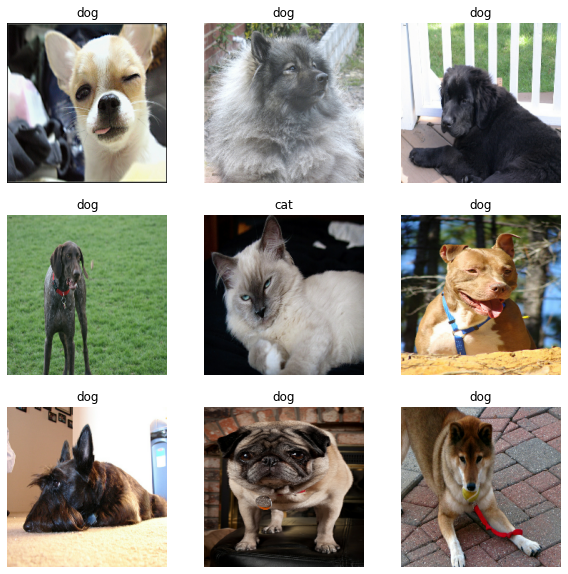

In [22]:
# Esta função é para obter os nomes das classes para quando for necessário fazer a correspondencia com a saída do modelo
class_names = train_dataset.class_names

# Aqui são mostradas algumas imagens da base de dados de treinamento
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
# Esta função é para ajustar o carregamento das imagens na memória para quando elas forem usadas no modelo 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
# É comum fazer variações das imagens para fazer um aumento de dados. Isso porque as imagens são todas em uma "direção",
# então caso o modelo encontrasse um animal de cabeça para baixo, ele teria diculdade de ententer se a etapa de data augmentation
# não fosse feita
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),])

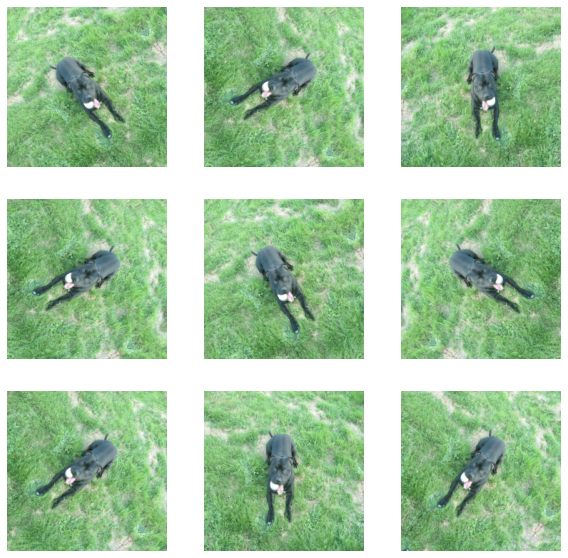

In [25]:
# Aqui alguns exemplos das imagens giradas para ver o resultado do data augmentation
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [26]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [27]:
# Aqui o modelo base a ser inicializado é a MobileNetV2. Esse modelo é pré-treinado então será feito apenas um refinamento
# para a base de dados escolhida. Um ponto positivo aqui é reduzir drasticamente o tempo de treinamento e também facilitar
# o trabalho de desenvovimento de modelo pois um modelo inciado do zero poderia ser complexo de ajustar os hiperparâmetros
# em pouco tempo.
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [29]:
base_model.trainable = False

In [30]:
# Visualização da arquitetura do modelo
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [31]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [32]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [33]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [36]:
len(model.trainable_variables)

2

In [37]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 4s 495ms/step - loss: 0.6816 - accuracy: 0.5597


In [38]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.68
initial accuracy: 0.56


In [39]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
45/45 [==============================] - 31s 614ms/step - loss: 0.6866 - accuracy: 0.5681 - val_loss: 0.5406 - val_accuracy: 0.6981
Epoch 2/10
45/45 [==============================] - 32s 698ms/step - loss: 0.5530 - accuracy: 0.6833 - val_loss: 0.4250 - val_accuracy: 0.7925
Epoch 3/10
45/45 [==============================] - 31s 687ms/step - loss: 0.4524 - accuracy: 0.7576 - val_loss: 0.3479 - val_accuracy: 0.8553
Epoch 4/10
45/45 [==============================] - 31s 691ms/step - loss: 0.3908 - accuracy: 0.8139 - val_loss: 0.2910 - val_accuracy: 0.8805
Epoch 5/10
45/45 [==============================] - 30s 671ms/step - loss: 0.3489 - accuracy: 0.8368 - val_loss: 0.2492 - val_accuracy: 0.9119
Epoch 6/10
45/45 [==============================] - 32s 715ms/step - loss: 0.3098 - accuracy: 0.8632 - val_loss: 0.2185 - val_accuracy: 0.9434
Epoch 7/10
45/45 [==============================] - 33s 723ms/step - loss: 0.2857 - accuracy: 0.8785 - val_loss: 0.1946 - val_accuracy: 0.9371

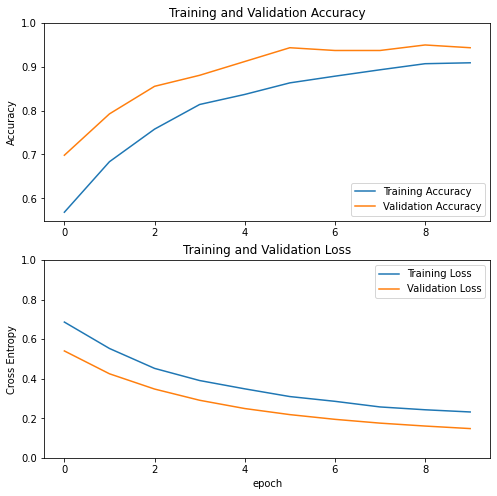

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [41]:
base_model.trainable = True

In [42]:
# Pegar o numero de camadas do modelo
print("Number of layers in the base model: ", len(base_model.layers))

# Escolher a camada a partir da qual começa o ajuste fino (as outras ficam congeladas como estão)
fine_tune_at = 100

# Congelar as outras camadas
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [43]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [45]:
len(model.trainable_variables)

56

## Escolha da quantidade de épocas de ajuste fino

Aqui eu escolhi esta quantidade (2) de épocas porque rodei o experimento outra vez até um total de 10 épocas para checar onde começa a possivelmente acontecer um overfitting. Segue abaixo a imagem do treinamento com 10 épocas de ajuste fino (o grafico apresenta os resultados também das 10 épocas do primeiro treinamento)

![alt text](Acuracia_perda_20_epocas.png "Resultados de um treinamento anterior")

# Ajuste fino

In [46]:
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/12
45/45 [==============================] - 48s 966ms/step - loss: 0.1365 - accuracy: 0.9444 - val_loss: 0.0425 - val_accuracy: 0.9874
Epoch 11/12
45/45 [==============================] - 43s 938ms/step - loss: 0.1025 - accuracy: 0.9646 - val_loss: 0.0281 - val_accuracy: 0.9937
Epoch 12/12
45/45 [==============================] - 43s 950ms/step - loss: 0.0790 - accuracy: 0.9694 - val_loss: 0.0219 - val_accuracy: 0.9937


In [47]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

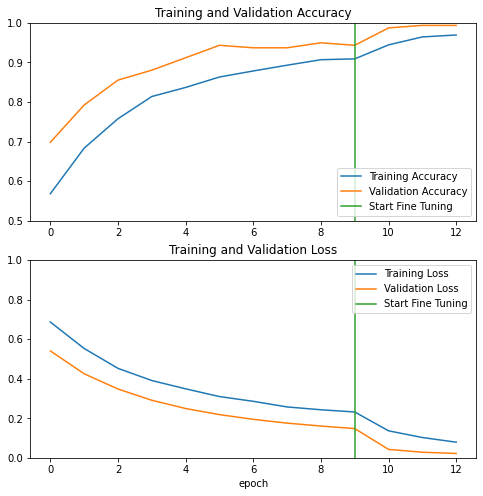

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [49]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

13/13 [==============================] - 8s 564ms/step - loss: 0.0279 - accuracy: 0.9925
Test accuracy : 0.9925187230110168


Predictions:
 [1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]
Labels:
 [1 1 0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0]


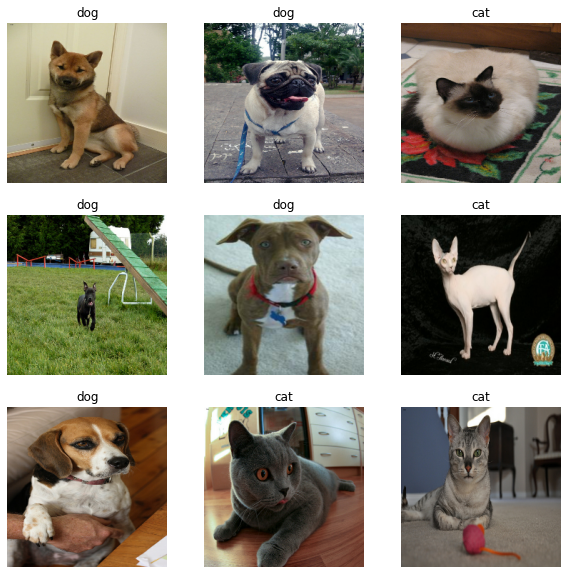

In [50]:
# Teste em lote da pasta test
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Esta parte é apenas para ajuste do resultado para valores binários indicando a classe inferida
# É usada uma função sigmoide para classificar os resultados
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Salvar o modelo

In [51]:
file_path = f"./img_classifier/v1/"
model.save(filepath=file_path, save_format='tf')

INFO:tensorflow:Assets written to: ./img_classifier/v1/assets


C:\Users\ferna\Anaconda3\envs\Projeto_CERTI\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Testar para verificar se o modelo está funcionando bem

In [52]:
# Verificar os nomes das classes
class_names

['cat', 'dog']

In [60]:
# Criar uma função para simplificar o processo de previsão do modelo
def prediction(image, c_model, class_name):
    """
    Esta função simplifica o processo de predição do modelo
    Ela recebe uma imagem, um modelo e os nomes das classes que devem ser retornados
    Ela retorna o nome da classe prevista
    """
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    
    img_array = tf.keras.utils.img_to_array(img)
    # Aqui é inserida mais uma dimensão à imagem porque o modelo espera uma lista e estamos enviando somente um item
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = c_model.predict(img_array).flatten()
    prediction = tf.nn.sigmoid(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    class_name = class_name[prediction[0]]
    
    return class_name

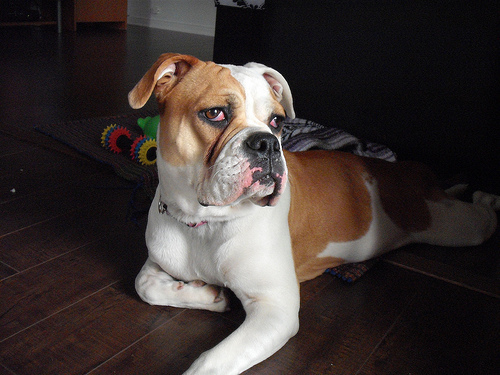

In [61]:
# Testando com imagens da pasta de validação (lembrar de verificar se esta imagem está realmente no conjunto de validação)
image_path = './dataset/validation/dog/american_bulldog_114.jpg'
img = PIL.Image.open(image_path)
img

In [62]:
prediction(image_path, model, class_names)

'dog'